In [1]:
import scipy.stats as ss
import pandas as pd
import numpy as np
data = pd.read_csv('../data/ift_data/ift_data_with_tp_classifications.csv')

The Mann-Whitney test is a non-parametric test for a difference in distribution between two datasets.

In [2]:
data_tp = data.loc[data.TP]
data_fp = data.loc[~data.TP]
print('TP: ', len(data_tp), 'FP: ', len(data_fp))

TP:  84 FP:  348


This initial dataset contains 84 identified true positives and 348 false positives. We are testing 8 variables as candidate parameters for a filter function. A prerequisite for use in the filter is that there is a difference in the distribution of the variable between true positive and false positives. If not, it isn't much use in a filter. We use a conservative adjustment for multiple hypothesis testing by dividing the threshold p-value by the number of variables being tested. 

In [2]:
variables = ['circularity', 'solidity',
             'tc_channel0', 'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
p_threshold = 0.05/len(variables)

In [4]:
results = {}
for var in variables:
    results[var] = {}
    u, p = ss.mannwhitneyu(data_tp[var], data_fp[var])
    results[var]['u'] = u
    results[var]['p'] = p
    results[var]['sig'] = p < p_threshold
    results[var]['del_median'] = np.round(data_tp[var].median() - data_fp[var].median(), 2)


In [5]:
results = pd.DataFrame(results).T
results

,u,p,sig,del_median
circularity,20731.5,0.0,True,0.15
solidity,21438.0,0.0,True,0.04
tc_channel0,20157.0,0.0,True,15.04
tc_channel1,20577.0,0.0,True,17.29
tc_channel2,20472.0,0.0,True,20.24
fc_channel0,21274.0,0.0,True,14.11
fc_channel1,20885.0,0.0,True,16.91
fc_channel2,7990.0,0.0,True,-94.55


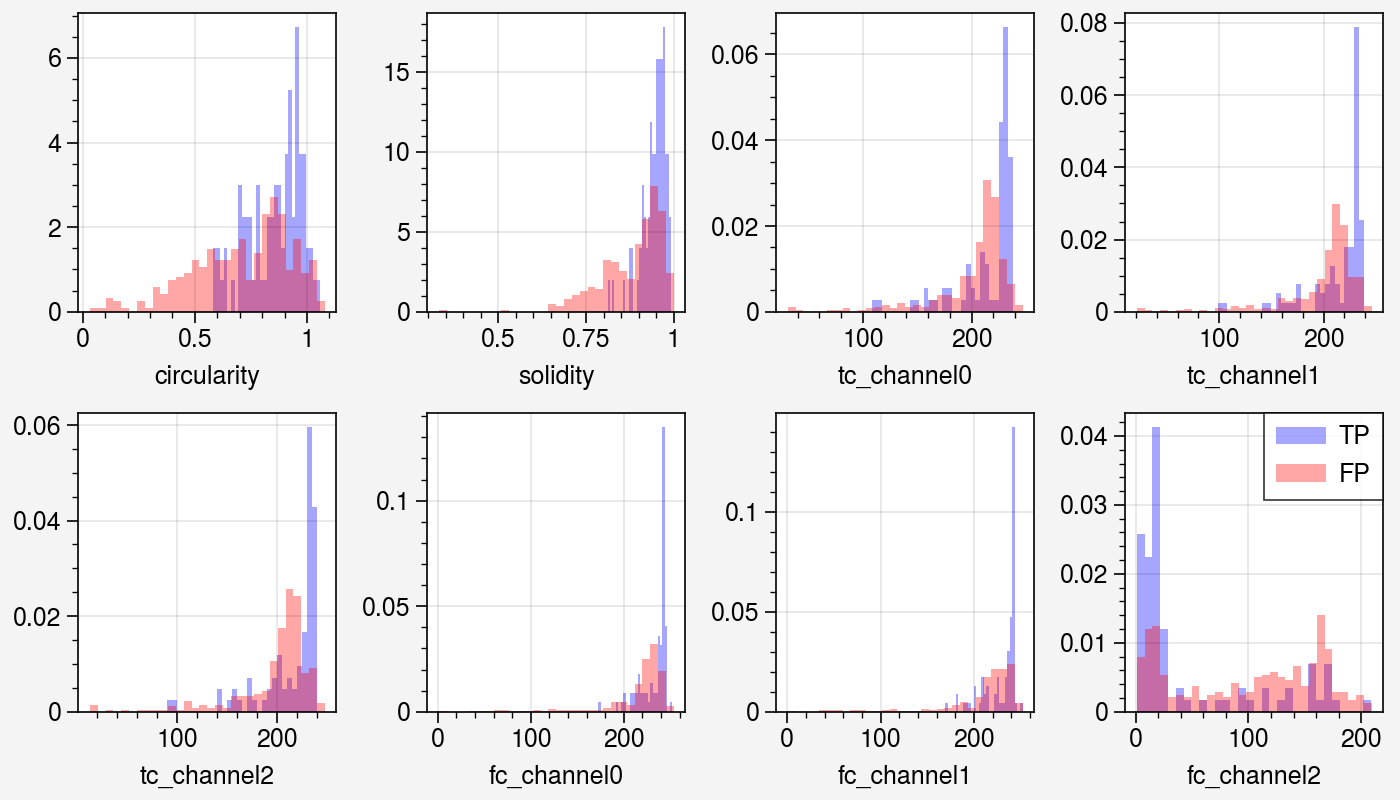

In [6]:
import proplot as pplt
fig, axs = pplt.subplots(width=7, height=4, 
                        nrows=2, ncols=4, share=False)
for var, ax in zip(variables, axs):
    ax.hist(data_tp[var], bins=30, color='b', alpha=0.35, density=True, label='TP')
    ax.hist(data_fp[var], bins=30, color='r', alpha=0.35, density=True, label='FP')
ax.legend(loc='ur', ncols=1)

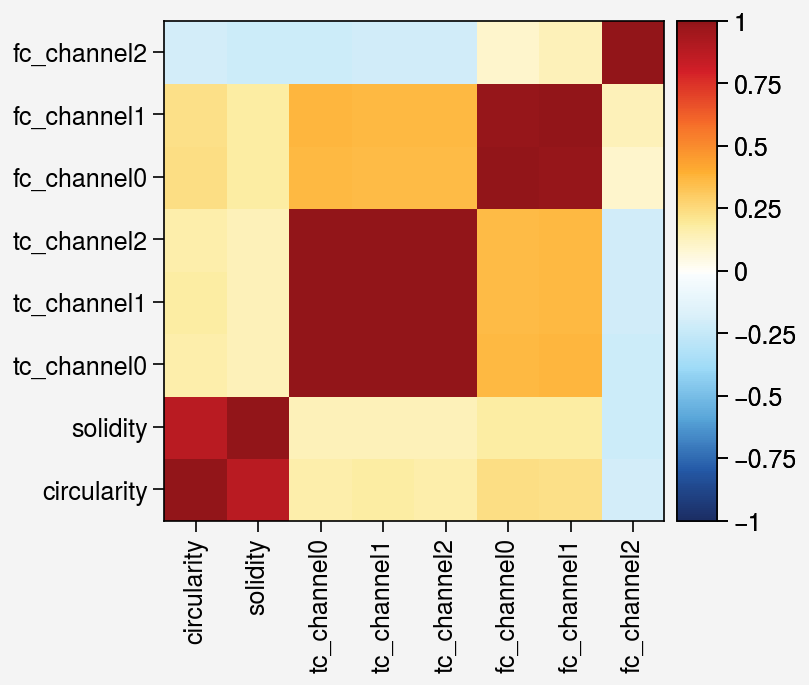

In [7]:
fig, ax = pplt.subplots()
ax.heatmap(data.corr().loc[variables, variables].round(2), vmin=-1, vmax=1, cmap='coldhot', colorbar='r')
ax.format(xrotation=90)

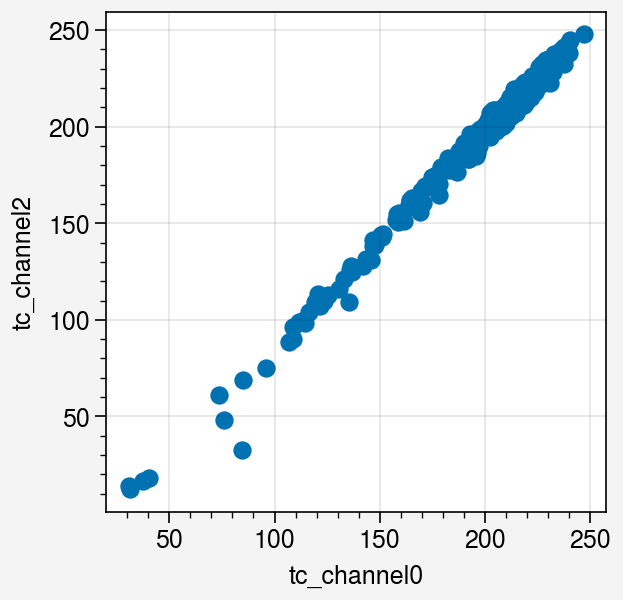

In [20]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.scatter(data['tc_channel0'], data['tc_channel2'])

# Logistic regression
Logistic regression in machine learning is commonly used as a classifier. We wish to assign probabilities to candidate floes to determine if they are true positives or false positives. We use two geometric quantities - circularity and solidity - and we use the pixel brightness in the six available channels (three each from the true color and false color images). The colors are likely not independent. So there is a subset of the color channels that will be useful. E.g., FC channels 0 and 1 are 99% correlated, as are TC channels 0 and 1.

We use the implementation of logistic regression in scikit-learn (citation), an open-source machine learning library for Python. This implementation uses a regularization term. The hyperparameters . Defaults used for the regularization constants (Cs=10), we set cv to 3-fold, and we set the score using the sklearn.metrics.f1_score (can also use fbeta_score). For the solver, we use 'liblinear', as that is recommended for small datasets.

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [21]:
# Scale the pixel brightness from 0 to 1
variables = ['circularity', # 'solidity',
             'tc_channel0',
#              'tc_channel1', 'tc_channel2',
             'fc_channel0', 'fc_channel1', 'fc_channel2']
data_scaled = data.copy()
for var in variables:
    if ('tc' in var) | ('fc' in var):
        data_scaled[var] = data_scaled[var]/255
X = data_scaled.loc[:, variables].to_numpy()
y = data_scaled['TP'].to_numpy()

In [39]:
# Select 1/3 of the data for use in the testing step
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1/3, random_state=10)
# Can stratify by region if eventually we get enough samples for that

In [40]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())



Optimization terminated successfully.
         Current function value: 0.407195
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.189     
Date:               2024-04-12 11:11 AIC:              244.5441  
No. Observations:   288              BIC:              262.8589  
Df Model:           4                Log-Likelihood:   -117.27   
Df Residuals:       283              LL-Null:          -144.67   
Converged:          1.0000           LLR p-value:      3.5898e-11
No. Iterations:     7.0000           Scale:            1.0000    
-------------------------------------------------------------------
        Coef.     Std.Err.      z      P>|z|     [0.025     0.975] 
-------------------------------------------------------------------
x1       2.4387     0.9818    2.4840   0.0130     0.5145     4.3630
x2      -4.6745     1.2439   -3.7580   0.0002    -7.1124  

In [31]:
clf = LogisticRegressionCV(Cs=10,
                     solver='lbfgs',
                     scoring='accuracy',
                     penalty='l2',
                     cv=10,
                     random_state=5).fit(X_train, y_train)

In [32]:
data['PredictedTP'] = clf.predict(X)

In [33]:
clf.score(X_test, y_test)

0.8263888888888888

In [34]:
clf.coef_

array([[ 3.68311162, -3.14607488,  4.72852306,  6.98394392, -3.54884674]])

In [35]:
data_scaled.loc[:, variables].max()

circularity    1.078932
tc_channel0    0.968178
fc_channel0    0.994150
fc_channel1    0.987810
fc_channel2    0.820015
dtype: float64

In [49]:
data['ProbabilityTP'] = clf.decision_function(X)

In [37]:
from sklearn.calibration import CalibrationDisplay

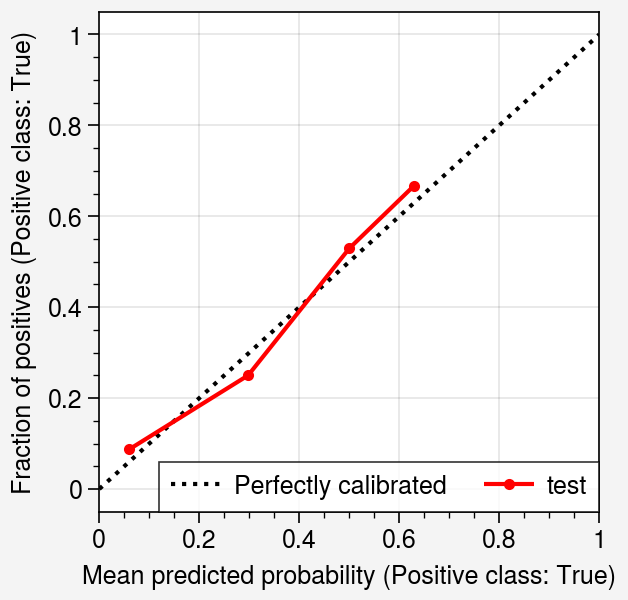

In [38]:
fig, ax = pplt.subplots()
display = CalibrationDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    n_bins=5,
    name='test',
    ax=ax,
    color='r',
    marker='.',
)

# Questions

This is the first time I've used logistic regression outside of possibly using it in a stats class some time ago. It is important that we are careful in our use of statistical tests and regression models so that we are avoiding common pitfalls and using the data as best we can. Some key questions:
1. How do we describe the confidence we have in the classifier model?
2. How should we interpret the calibration curve? If I'm understanding it right, we need to be able to have enough measurements in each predicted probability bin to make an estimate. Above the curve means that we are being overly conservative, and have therefore a higher false negative rate, and below the curve means that we have a higher false positive rate. (I think)
3. How do we choose the appropriate variables for the classifier? We have lots of choices, and there's a lot of values that are correlated with each other. How do we choose the right variables to use?

# Application of Simon's true-positive identification functions

In order to train the logistic regression function, we need to have good data for the true and false positives. There is some kind of an issue with the falsecolor images when I tried implementing the filter earlier. I'd like to be able to generate the list of floes and true positive flags with additional information.


In [2]:
%run ../scripts/floewise_img_process.py

In [3]:
import h5py
import pandas as pd
from os.path import join
from os import listdir
import numpy as np
from skimage.measure import regionprops_table
import rasterio as rio
from rasterio.plot import reshape_as_image
import proplot as pplt

caselist_loc = '../data/validation_tables/qualitative_assessment_tables/all_100km_cases.csv'
eval_table_loc = '../data/ift_data/ift_pipeline_default/eval_tables/'
assign_table_loc = '../data/validation_tables/floe_labeling_tables/'
label_floe_loc = '../data/validation_images/labeled_floes_png/'
image_loc = '../data/validation_images/'

df_cases = pd.read_csv(caselist_loc, index_col=0)

# this is to make it easier to link the filenames and case numbers
case_reference = pd.DataFrame({'case_number': df_cases.loc[df_cases.satellite=='aqua', 'case_number'].values,
                               'location': [x[4:] for x in df_cases.loc[df_cases.satellite=='aqua', 'long_name'].values]})

# this has the results on whether IFT ran to completion on each
df_eval = pd.concat([pd.read_csv(eval_table_loc + file) for file in listdir(eval_table_loc) if '.csv' in file])
df_eval['startdate'] = pd.to_datetime(df_eval['startdate'].values)
df_eval.reset_index(inplace=True, drop=True)
df_eval['region'] = [x.split('-100km')[0] for x in df_eval['location']]

# grabbing the assignments here so I know what folder to look in for un-reviewed floe labels
df_assign = pd.concat([pd.read_csv(assign_table_loc + file, index_col=0) for file in listdir(assign_table_loc) if '.csv' in file]) 
df_assign.reset_index(inplace=True, drop=True)

# this adds the case number to the evaluation files and pulls out the columns we need
df_merged = df_eval.merge(case_reference, left_on='location',
                          right_on='location').loc[:,
                                ['region', 'case_number', 'location',
                                 'startdate', 'enddate', 'preprocess', 'tracker']]
# add filenames for relevant images
df_merged['truecolor_aqua'] = ['_'.join([str(cn).zfill(3), region,
                                         '100km', start_date.strftime('%Y%m%d')]) + \
                                   '.aqua.truecolor.250m.tiff' for cn, region, start_date in zip(
                                        df_merged['case_number'],
                                        df_merged['region'],
                                        df_merged['startdate'])]
df_merged['falsecolor_aqua'] = [x.replace('true', 'false') for x in df_merged['truecolor_aqua']]
df_merged['truecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['truecolor_aqua']]
df_merged['falsecolor_terra'] = [x.replace('aqua', 'terra') for x in df_merged['falsecolor_aqua']]

# add info on who was assigned the initial floe labeling
df_merged = df_merged.merge(df_assign.loc[:, ['case_number', 'fl_analyst']],
                            left_on='case_number', right_on='case_number', how='outer')

# check if the floe labeling PNG has been created
labeled_floes = listdir(label_floe_loc)
df_merged['aqua_labeled_floes'] = False
df_merged['terra_labeled_floes'] = False
for idx, row in df_merged.iterrows():
    if row['truecolor_aqua'].split('.')[0].replace('_100km', '') + '_aqua_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'aqua_labeled_floes'] = True
    if row['truecolor_terra'].split('.')[0].replace('_100km', '') + '_terra_labeled_floes.png' in labeled_floes:
        df_merged.loc[idx, 'terra_labeled_floes'] = True
df_merged.set_index('case_number', inplace=True)
df_merged.sort_index(inplace=True)

In [11]:
for cn, row in df_merged.loc[(df_merged.tracker == 'pass') & (df_merged.aqua_labeled_floes == True)].iterrows():
    break

In [12]:
row

region                                                        baffin_bay
location                     baffin_bay-100km_by_100km-20140329-20140330
startdate                                            2014-03-29 00:00:00
enddate                                                       2014-03-30
preprocess                                                          pass
tracker                                                             pass
truecolor_aqua         023_baffin_bay_100km_20140329.aqua.truecolor.2...
falsecolor_aqua        023_baffin_bay_100km_20140329.aqua.falsecolor....
truecolor_terra        023_baffin_bay_100km_20140329.terra.truecolor....
falsecolor_terra       023_baffin_bay_100km_20140329.terra.falsecolor...
fl_analyst                                                            ES
aqua_labeled_floes                                                  True
terra_labeled_floes                                                 True
Name: 23, dtype: object

In [26]:
import os
ift_dataloc = '../data/ift_data/ift_pipeline_minarea_100px/ift_results/'
man_dataloc = '../data/validation_images/labeled_floes_png/021_baffin_bay_20120422_aqua_labeled_floes.png'
lmask_loc = '../data/validation_images/landmask/'
reflectance_loc = '../data/validation_images/'
region = row.region
satellite = 'aqua'
case_number = str(cn).zfill(3)
h5_files = os.listdir(ift_dataloc + row.region + '/' + row.location + '/preprocess/hdf5-files')
for f in h5_files:
    if satellite in f:
        h5_file = ift_dataloc + '/' + row.region + '/' + row.location + '/preprocess/hdf5-files/' + f
floewise_img_process(
                manual_path=man_dataloc + '_'.join([case_number, region, row.startdate.strftime('%Y%m%d'), satellite, 'labeled_floes.png']), 
                ift_path=h5_file,
                land_mask_path=lmask_loc + '_'.join([case_number, region, 'landmask.tiff']), 
                tc_image_path=reflectance_loc + 'truecolor/' + row['truecolor_' + satellite],
                fc_image_path=reflectance_loc + 'falsecolor/' + row['falsecolor_' + satellite],
                threshold_params={'min_area': 100, 'max_area': 90000}
                )

[ WARN:0@337395.450] global loadsave.cpp:248 findDecoder imread_('../data/validation_images/labeled_floes_png/021_baffin_bay_20120422_aqua_labeled_floes.png023_baffin_bay_20140329_aqua_labeled_floes.png'): can't open/read file: check file path/integrity


TypeError: object of type 'NoneType' has no len()